# Importing Things

In [ ]:
# took 30 minutes to run

using Pkg
Pkg.add(["IncompressibleNavierStokes", "CairoMakie", "ReadVTK", "Distributions", "HDF5", "MAT"])

In [81]:
# using GLMakie #!md
using IncompressibleNavierStokes

# Output directory for saving results
outdir = joinpath(@__DIR__, "output")
mkdir(outdir)
outdir = joinpath(@__DIR__, "output", "RayleighBenard2D")
mkdir(outdir)
backend = IncompressibleNavierStokes.CPU()

KernelAbstractions.CPU(false)

In [4]:
# using CUDA, CUDSS
# backend = CUDABackend()

using CairoMakie, Distributions, Random, ReadVTK

# Initial Setup:

In [69]:
T = Float32

# Temperature equation setup.
temperature = temperature_equation(;
    Pr=T(1),
    Ra=T(1e8),
    Ge=T(1.0),
    dodissipation=true,
    boundary_conditions=(
        (SymmetricBC(), SymmetricBC()),
        (DirichletBC(T(1)), DirichletBC(T(0))),
    ),
    gdir=2,
    nondim_type=1,
)

(α1 = 0.0001f0, α2 = 1.0f0, α3 = 0.0001f0, α4 = 0.0001f0, γ = 1.0f0, dodissipation = true, boundary_conditions = ((SymmetricBC(), SymmetricBC()), (DirichletBC{Float32}(1.0f0), DirichletBC{Float32}(0.0f0))), gdir = 2)

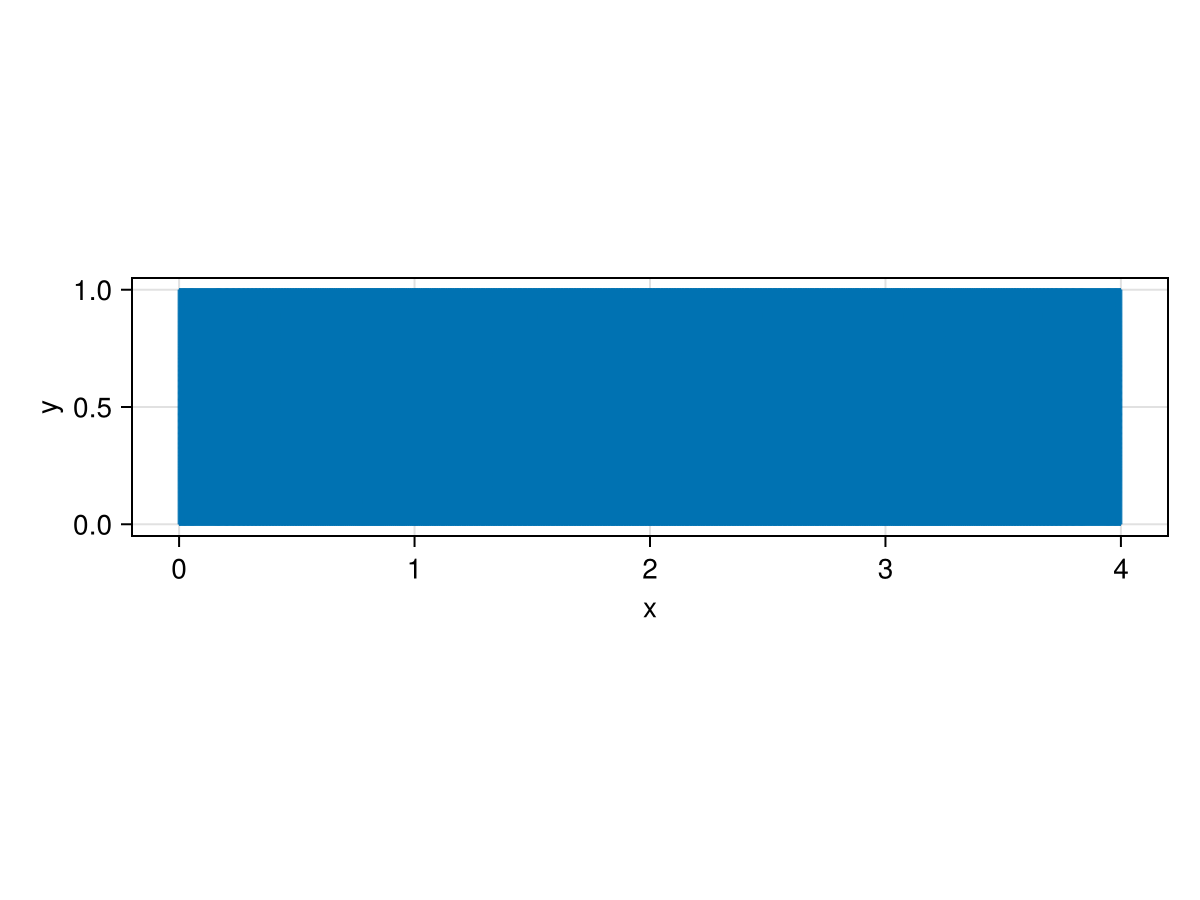

In [70]:
n_1 = 512
n_2 = 384
x = tanh_grid(T(0), T(4), n_1, T(1.2)), tanh_grid(T(0), T(1), n_2, T(1.2))
plotgrid(x...)

In [71]:
setup = Setup(;
    x,
    boundary_conditions=((DirichletBC(), DirichletBC()), (DirichletBC(), DirichletBC())),
    Re=1 / temperature.α1,
    temperature,
    backend,
);

# Reaching the Steady-State

In [72]:
# Initial conditions
ustart = velocityfield(setup, (dim, x, y) -> zero(x));
tempstart = temperaturefield(setup, (x, y) -> 0.5 + rand(Normal(0, 1e-5)) * y * (1 - y));

In [ ]:
processors = (;
    log=timelogger(; nupdate=1000),
    animation=animator(; setup=setup, fieldname=:temperature, path="output_temp.mp4",
        colormap=:seaborn_icefire_gradient,),
)

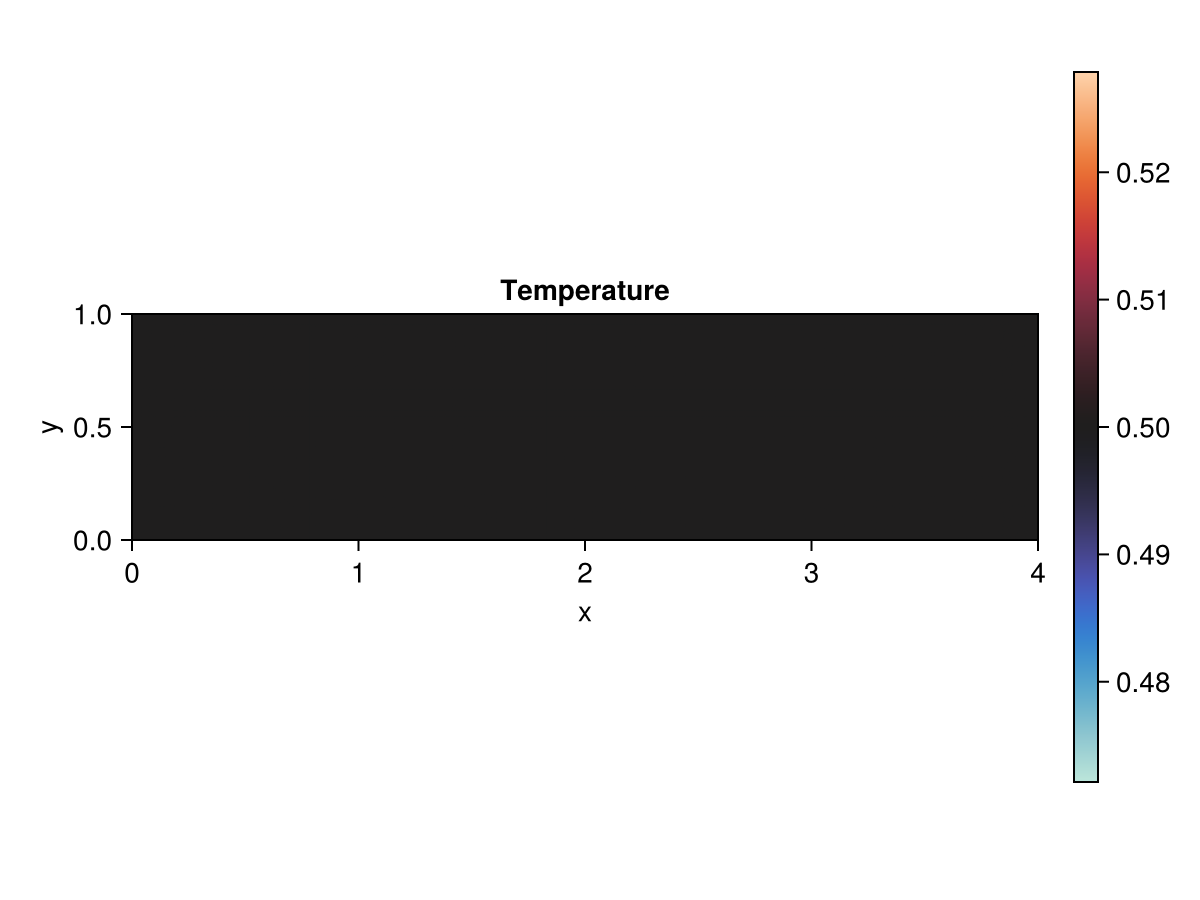

In [74]:
state, outputs = solve_unsteady(;
    setup,
    ustart,
    method = RKMethods.RK56(; T = eltype(ustart)),
    tempstart,
    tlims=(T(0), T(50)),
    # tlims=(T(0), T(1)),
    Δt=T(1e-2),
    processors,
);

In [ ]:
using HDF5

psolver = default_psolver(setup)
function hdf5_writer(path, state)
    h5open(path, "w") do file
        file["velocity"] = state.u
        file["temp"] = state.temp
        file["pressure"] = observefield(Observable(state); setup=setup, fieldname=:pressure, psolver=psolver)[]
        file["time"] = state.t
    end
end

hdf5_writer("steady_state_output.h5", state)

# Start Collecting the data

In [76]:
function hdf5_writer(path, state)
    state = state[]
    h5open(path, "w") do file
        file["velocity"] = state.u
        file["temp"] = state.temp
        file["pressure"] = observefield(Observable(state); setup=setup, fieldname=:pressure, psolver=psolver)[]
        file["time"] = state.t
    end
end

function hdf5_writer_initialize(state; path="/content/output/RayleighBenard2D/sol")
    s = 0

    on(state) do (; n, t)
        hdf5_writer("$(path)_$(n).h5", state)
    end

    s
end

hdf5_writer_finalize(i, state) = hdf5_writer("final.h5", state)
hdf5_writer_processor = processor(hdf5_writer_initialize,hdf5_writer_finalize)

(initialize = Main.hdf5_writer_initialize, finalize = Main.hdf5_writer_finalize)

In [77]:
outdir = joinpath(@__DIR__, "output", "RayleighBenard2D")

"/content/output/RayleighBenard2D"

In [ ]:
processors = (;
    log=timelogger(; nupdate=1000),
    animation=animator(; setup=setup, fieldname=:temperature, path=joinpath("output_temp_1.mp4"),
        colormap=:seaborn_icefire_gradient,),
        hdf5_writer_processor
)

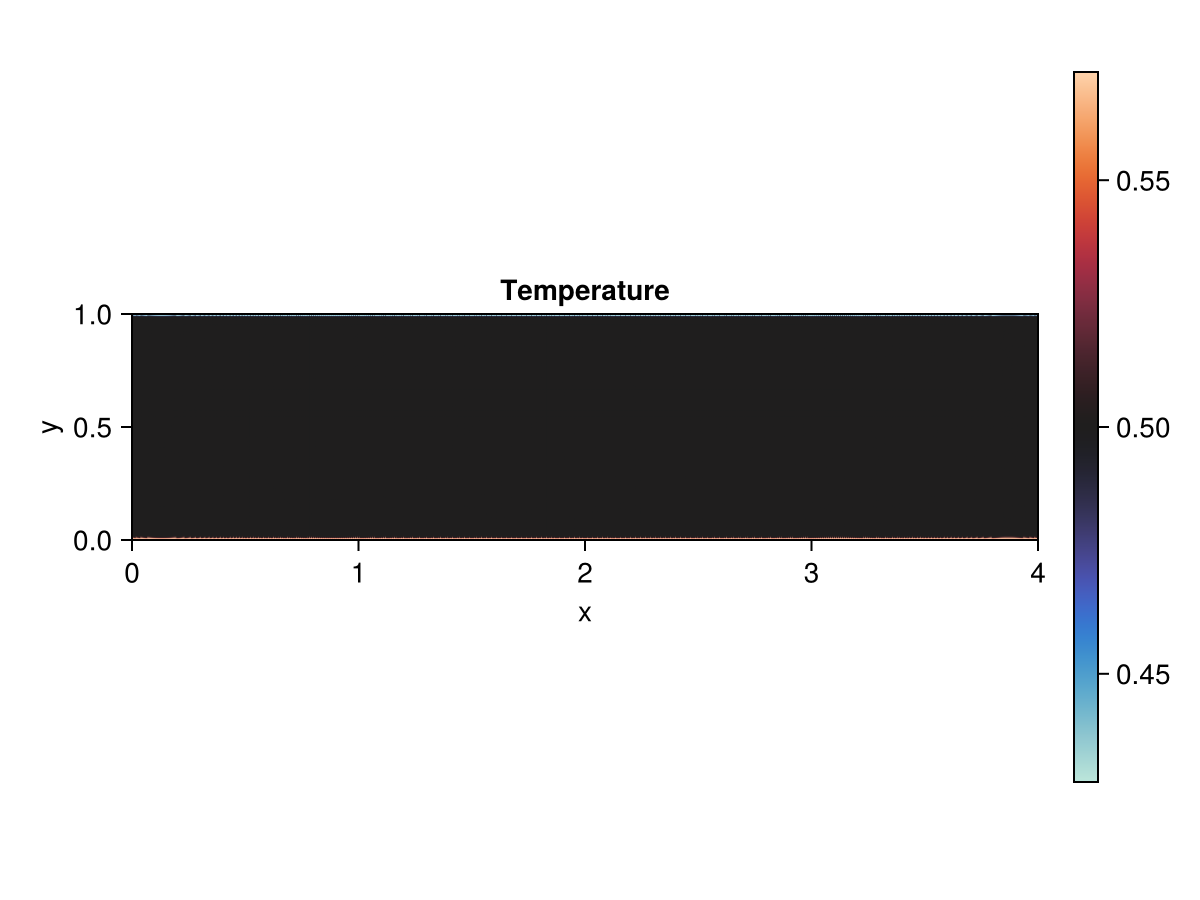

In [88]:
tlims=(T(0), T(10))
Δt=T(1e-2)

state_, outputs = solve_unsteady(;
    setup,

    # start from the state where we had left
    ustart=state.u,
    tempstart=state.temp,
    method = RKMethods.RK56(; T = eltype(ustart)),
    tlims=tlims,
    Δt=Δt,
    processors,
);

# Saving the data

In [ ]:
;zip -r yup.zip /content/output/RayleighBenard2D

In [89]:
function load_and_concatenate(folder_path::String, num_files::Int)
    U_list, W_list, P_list, T_list, time = [], [], [], [], Float64[]

    for f in 1:num_files
        filename = joinpath(folder_path, "sol_$(f).h5")
        try
            h5open(filename, "r") do file
                P = permutedims(read(file["pressure"]))
                T = permutedims(read(file["temp"])[2:end-1, 2:end-1])
                U = permutedims(read(file["velocity"])[2:end-1, 2:end-1, 1])
                W = permutedims(read(file["velocity"])[2:end-1, 2:end-1, 2])

                push!(P_list, P)
                push!(T_list, T)
                push!(U_list, U)
                push!(W_list, W)
                push!(time, read(file["time"]))
            end
        catch e
            println("Error at $f: $e")
            return nothing, nothing
        end
    end

    P_all = cat(P_list..., dims=3)
    T_all = cat(T_list..., dims=3)
    U_all = cat(U_list..., dims=3)
    W_all = cat(W_list..., dims=3)

    data = cat(U_all, W_all, P_all, T_all; dims=4)  # (nx, ny, nfiles, 4)
    return data, time
end

load_and_concatenate (generic function with 1 method)

In [ ]:
folder_path = "/content/output/RayleighBenard2D"
data, time = load_and_concatenate(folder_path, Int((tlims[2]-tlims[1])/Δt))

In [ ]:
# Saving the files
path = "grid.h5"
h5open(path, "w") do file
    file["x"] = x[1][1:end-1]
    file["y"] = x[2][1:end-1]
end

h5open("data.h5", "w") do file
    file["data"] = data
    file["time"] = time
end


In [92]:
using MAT

save_dict = Dict(
    "data" => data,
    "x"    => x[1][1:end-1],
    "z"    => x[2][1:end-1],
    "t"    => time,
)

matwrite("data1e8.mat", save_dict)